# Object Localization with TensorFlow

## Includes

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
tf.config.list_physical_devices('GPU')

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.9.1
Num GPUs Available 1


In [2]:
path=os.getcwd()
emojis_path=path+"\\emojis\\openmoji-72x72-color\\"

# Load data

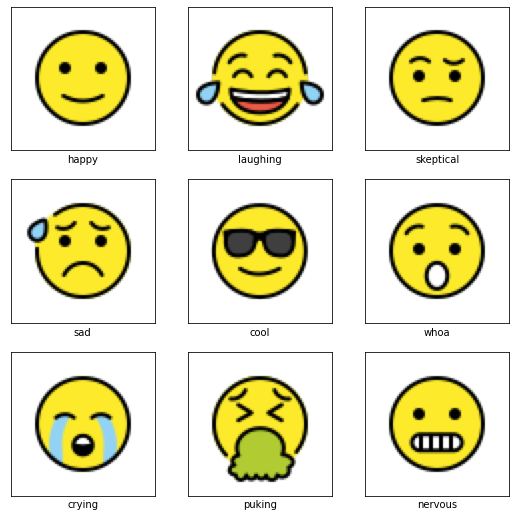

In [3]:
emojis = {
    0: {'name': 'happy', 'file': emojis_path+'1F642.png'},
    1: {'name': 'laughing', 'file': emojis_path+'1F602.png'},
    2: {'name': 'skeptical', 'file': emojis_path+'1F928.png'},
    3: {'name': 'sad', 'file': emojis_path+'1F630.png'},
    4: {'name': 'cool', 'file': emojis_path+'1F60E.png'},
    5: {'name': 'whoa', 'file': emojis_path+'1F62F.png'},
    6: {'name': 'crying', 'file': emojis_path+'1F62D.png'},
    7: {'name': 'puking', 'file': emojis_path+'1F92E.png'},
    8: {'name': 'nervous', 'file': emojis_path+'1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [5]:
emojis

{0: {'name': 'happy',
  'file': 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\emojis\\openmoji-72x72-color\\1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x17FA24B6460>},
 1: {'name': 'laughing',
  'file': 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\emojis\\openmoji-72x72-color\\1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x17FAA7674F0>},
 2: {'name': 'skeptical',
  'file': 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\emojis\\openmoji-72x72-color\\1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x17FAA767C70>},
 3: {'name': 'sad',
  'file': 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\emojis\\openmoji-72x72-color\\1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x17FAA7676A0>},
 4: {'name': 'cool',
  'file': 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\emojis\\openmoji-72x72-color\\1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x17FAA767910>},
 5: {'name'

## Setting emoji on an empty image

In [6]:
# Include the emoji in a random position of a 144*144 empty image. The emoji size is 72*72
def create_example():
    class_id = np.random.randint(0,9)
    image = np.ones((144,144,3)) * 255
    row = np.random.randint(0,72)
    col = np.random.randint(0,72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144  # +10 for crop the emoji


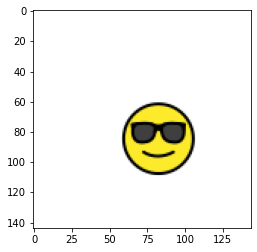

In [7]:
image,class_id, row, col = create_example()
plt.imshow(image);

## Set bounding box

In [8]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    if norm:
        image *=255.
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3) # 52 because 72-10

    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col + 52, row + 52), outline='blue', width=3) # 52 because 72-10
    return image

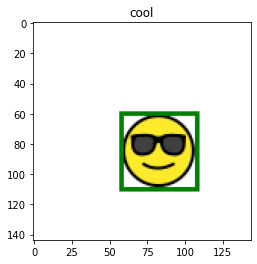

In [9]:
image = plot_bounding_box(image, gt_coords=[row,col])
plt.imshow(image);
plt.title(emojis[class_id]['name'])
plt.show()

# Generation Data

In [10]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range (0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch} # get the output in two dictionaries

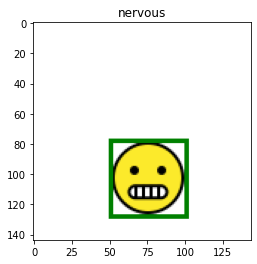

In [11]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]
image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image);
plt.title(emojis[class_id]['name'])
plt.show()

# Model

In [12]:
input_ = Input(shape=(144, 144, 3), name='image')
x = input_

for i in range(0, 5):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out,box_out])
# model.summary()

## IoU metric

In [13]:
# Calculate the error of the prediction with intersection over union. if returns 0, the predict fail. If it returns 1 or values close to 1, the predict is OK. 
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou =  self.add_weight(name='iou', initializer='zeros')
        self.total_iou=  self.add_weight(name='total_iou', initializer='zeros')
        self.num_examples=  self.add_weight(name='num_examples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2): 
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1) 

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)
        
        i_area = get_area(i_x1, i_y1, i_x2, i_y2) #  intersection area
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area # union area
        
        iou = tf.math.divide(i_area, u_area)
        self.num_examples.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_examples)

    def result(self):
        return self.iou

    def reset_state(self):
        self.iou =  self.add_weight(name='iou', initializer='zeros')
        self.total_iou=  self.add_weight(name='total_iou', initializer='zeros')
        self.num_examples=  self.add_weight(name='num_examples', initializer='zeros')

# Compile the model

In [14]:
model.compile(
    loss={'class_out': 'categorical_crossentropy', 'box_out': 'mse'},
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={'class_out': 'accuracy', 'box_out': IoU(name='iou')}
)

# Test the model

In [15]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']

    image  = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'white'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])

In [16]:
def test(model):
    test_datagen = data_generator(1)
    plt.figure(figsize=(16, 4))
    for i in range(0, 6):
        plt.subplot(1, 6, i+1)
        test_model(model, test_datagen)
    plt.show()

In [17]:
# test(model)

In [18]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

# Train the model

In [ ]:
tf.config.list_physical_devices('GPU')

def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

_ = model.fit(
    data_generator(), 
    epochs=50, 
    steps_per_epoch=300,
    callbacks=[
        ShowTestImages(), 
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

Epoch 1/50


In [1]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']
